In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.io import loadmat

In [5]:
from pathlib import Path
import h5py

DATA_DIR = Path("./12.CapacitorElectricalStress")

def load_es_h5(file_name: str) -> h5py.File:
    path = DATA_DIR / file_name

    if not path.exists():
        raise FileNotFoundError(f"💥 File not found: {path}")

    print(f"📂 Loading (HDF5): {path}")
    # h5py.File オブジェクトをそのまま返す
    return h5py.File(str(path), "r")


In [6]:
f_es10 = load_es_h5("ES10.mat")
list(f_es10.keys())

📂 Loading (HDF5): 12.CapacitorElectricalStress/ES10.mat


['#refs#', 'ES10']

In [ ]:
def print_tree(h5obj, indent=0):
    cnt = 0
    for key, item in h5obj.items():
        print(" " * indent + f"- {key} ({type(item).__name__})")
        if isinstance(item, h5py.Group):
            print_tree(item, indent + 2)
        cnt += 1
    print(cnt)

f_es10 = load_es_h5("ES10.mat")
print_tree(f_es10)

In [13]:
import numpy as np
import pandas as pd

def extract_timeseries(h5, sample="ES10C7"):
    timestamp = np.array(h5["Serial_Date"]).ravel()

    vl = np.array(h5[sample]["VL"]).ravel()
    vo = np.array(h5[sample]["VO"]).ravel()

    df = pd.DataFrame({
        "timestamp": timestamp,
        "VL": vl,
        "VO": vo, 
        "sample": sample
    })

    return df

df7 = extract_timeseries(f_es10, "ES10C7")
df7.head()


KeyError: "Unable to synchronously open object (object 'Serial_Date' doesn't exist)"

In [14]:
import h5py

def find_paths_with(h5obj, name_substring, prefix=""):
    """
    name_substring を名前に含む Dataset / Group のパスを全部列挙するやつ
    """
    hits = []
    for key, item in h5obj.items():
        path = f"{prefix}/{key}" if prefix else key
        if name_substring in key:
            hits.append((path, type(item).__name__))
        if isinstance(item, h5py.Group):
            hits.extend(find_paths_with(item, name_substring, prefix=path))
    return hits

print(find_paths_with(f_es10, "Serial"))
print(find_paths_with(f_es10, "ES10C7"))
print(find_paths_with(f_es10, "VL"))


[('ES10/Transient_Data/Serial_Date', 'Dataset')]
[('ES10/EIS_Data/ES10C7', 'Group'), ('ES10/Transient_Data/ES10C7', 'Group')]
[('#refs#/VL', 'Dataset'), ('#refs#/VLb', 'Dataset'), ('ES10/Transient_Data/ES10C1/VL', 'Dataset'), ('ES10/Transient_Data/ES10C2/VL', 'Dataset'), ('ES10/Transient_Data/ES10C3/VL', 'Dataset'), ('ES10/Transient_Data/ES10C4/VL', 'Dataset'), ('ES10/Transient_Data/ES10C5/VL', 'Dataset'), ('ES10/Transient_Data/ES10C6/VL', 'Dataset'), ('ES10/Transient_Data/ES10C7/VL', 'Dataset')]


In [15]:
import numpy as np
import pandas as pd

TRANSIENT_ROOT = "ES10/Transient_Data"
SERIAL_PATH = f"{TRANSIENT_ROOT}/Serial_Date"

def extract_transient_one(h5, cap_name="ES10C7"):
    """
    h5: h5py.File
    cap_name: 'ES10C1' ~ 'ES10C7'
    """
    time = np.array(h5[SERIAL_PATH]).ravel()

    base = f"{TRANSIENT_ROOT}/{cap_name}"
    vl = np.array(h5[f"{base}/VL"]).ravel()
    vo = np.array(h5[f"{base}/VO"]).ravel()

    # 長さが微妙に違ってても困らないように揃える
    n = min(len(time), len(vl), len(vo))
    time = time[:n]
    vl = vl[:n]
    vo = vo[:n]

    df = pd.DataFrame(
        {
            "timestamp": time,
            "VL": vl,
            "VO": vo,
            "sample": cap_name,
        }
    )
    return df

df7 = extract_transient_one(f_es10, "ES10C7")
df7.head()


,timestamp,VL,VO,sample
0,735920.549965,0.128412,0.107936,ES10C7
1,735920.551354,1.720740,1.943773,ES10C7
2,735920.552743,1.670350,2.304510,ES10C7
3,735920.554132,1.628022,2.641131,ES10C7
4,735920.555521,1.587206,2.971220,ES10C7


Text(0.5, 0, 'Serial_Date (raw)')

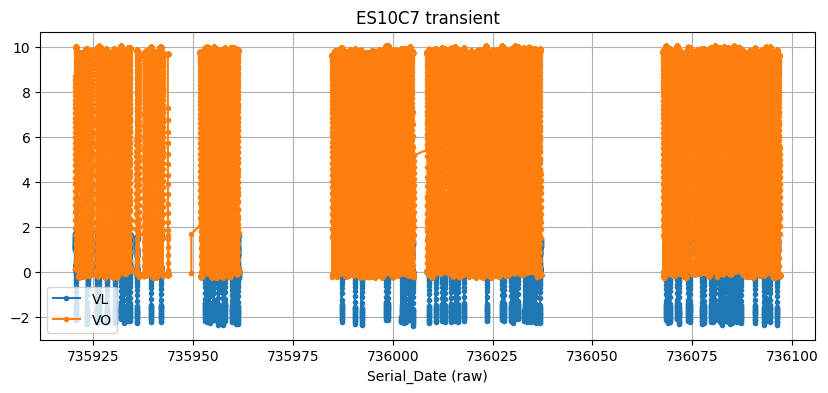

In [16]:
ax = df7.plot(
    x="timestamp",
    y=["VL", "VO"],
    figsize=(10, 4),
    grid=True,
    style=".-",
    title="ES10C7 transient"
)
ax.set_xlabel("Serial_Date (raw)")


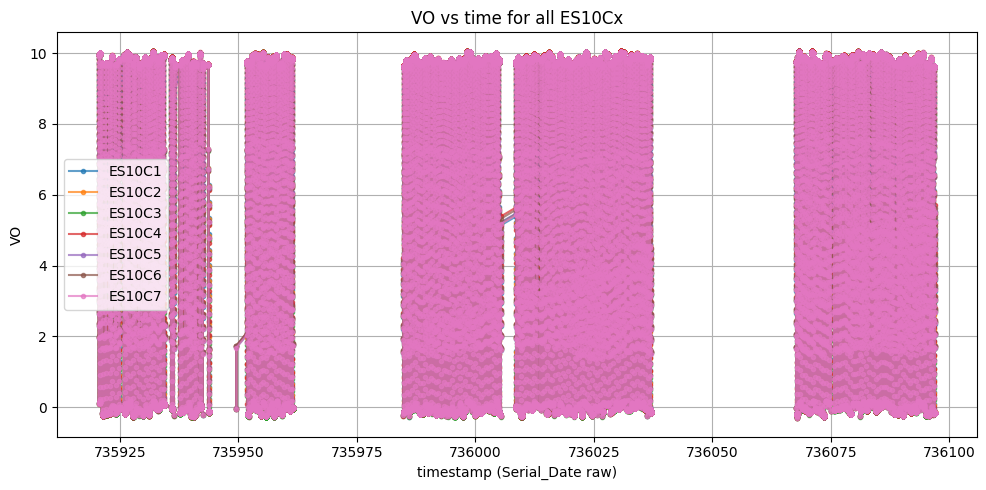

In [18]:
import matplotlib.pyplot as plt

def list_caps(h5):
    grp = h5[TRANSIENT_ROOT]
    return [k for k in grp.keys() if k.startswith("ES10C")]

caps = list_caps(f_es10)
caps


df_list = [extract_transient_one(f_es10, cap) for cap in caps]
df_all = pd.concat(df_list, ignore_index=True)
df_all.head()


fig, ax = plt.subplots(figsize=(10, 5))
for cap in caps:
    sub = df_all[df_all["sample"] == cap]
    ax.plot(sub["timestamp"], sub["VO"], marker=".", linestyle="-", label=cap, alpha=0.7)

ax.set_xlabel("timestamp (Serial_Date raw)")
ax.set_ylabel("VO")
ax.grid(True)
ax.legend()
ax.set_title("VO vs time for all ES10Cx")
plt.tight_layout()


In [21]:
def extract_segments(df, segment_size=2000):
    """波形を等間隔 or 変動サイクルごとに切る"""
    segments = []
    for i in range(0, len(df), segment_size):
        seg = df.iloc[i:i+segment_size]
        if len(seg) == segment_size:
            segments.append(seg)
    return segments

import numpy as np

def features_from_segment(seg):
    vo = seg["VO"].values.astype(float).reshape(-1)

    # 全部 NaN なら None 返しておく
    if np.isnan(vo).all():
        return None

    return {
        "v_max": np.nanmax(vo),
        "v_min": np.nanmin(vo),
        "peak_to_peak": np.nanmax(vo) - np.nanmin(vo),
        "rms": np.sqrt(np.nanmean(vo**2)),
        "slew_rise": np.nanmax(np.diff(vo)),
        "slew_fall": np.nanmin(np.diff(vo)),
    }


In [22]:
segments = extract_segments(df7)

feature_rows = [features_from_segment(seg) for seg in segments]
feature_df = pd.DataFrame(feature_rows)
feature_df.head()


,v_max,v_min,peak_to_peak,rms,slew_rise,slew_fall
0,10.014149,-0.231698,10.245847,6.288270,1.897131,-2.663838
1,10.020178,-0.188490,10.208668,6.321272,1.845885,-2.603547
2,9.933761,-0.257321,10.191082,6.263067,1.929791,-2.640224
3,10.036757,-0.223660,10.260417,6.331799,1.871005,-2.634197
4,9.960390,-0.227678,10.188068,6.310059,1.881055,-2.655800


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

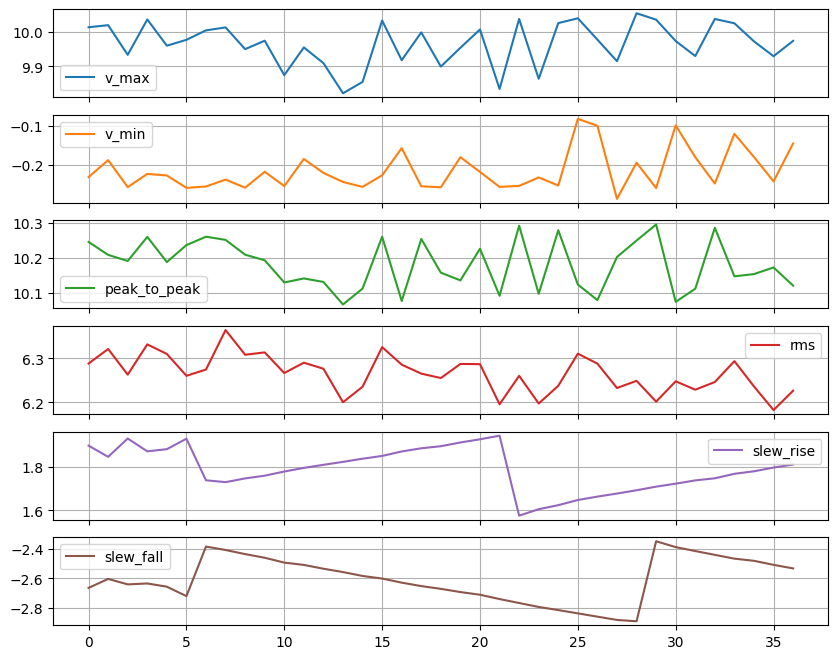

In [23]:
feature_df.plot(subplots=True, figsize=(10,8), grid=True)

In [24]:
vo_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VO"])
vl_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VL"])

print("VO shape:", vo_raw.shape)
print("VL shape:", vl_raw.shape)


VO shape: (75826, 400)
VL shape: (75826, 400)


In [25]:
import numpy as np
import pandas as pd

def to_waveforms(arr):
    # (n_waveforms, n_samples) にそろえる
    if arr.shape[0] < arr.shape[1]:
        return arr  # もうこの形
    else:
        return arr.T

vo_wf = to_waveforms(vo_raw)  # shape = (n_waveforms, n_samples)
vl_wf = to_waveforms(vl_raw)

print("waveforms:", vo_wf.shape)

def features_from_waveform(vo, vl=None, idx=0):
    vo = vo.astype(float)

    feats = {
        "idx": idx,
        "v_max": vo.max(),
        "v_min": vo.min(),
        "peak_to_peak": vo.max() - vo.min(),
        "rms": np.sqrt(np.mean(vo**2)),
        "slew_rise": np.max(np.diff(vo)),
        "slew_fall": np.min(np.diff(vo)),
    }

    if vl is not None:
        vl = vl.astype(float)
        feats["vl_rms"] = np.sqrt(np.mean(vl**2))

    return feats

rows = []
for i in range(vo_wf.shape[0]):
    rows.append(features_from_waveform(vo_wf[i], vl_wf[i], idx=i))

feature_df = pd.DataFrame(rows)
feature_df.head()


waveforms: (400, 75826)


,idx,v_max,v_min,peak_to_peak,rms,slew_rise,slew_fall,vl_rms
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
def segment_stats(segments):
    nan_ratios = []
    for seg in segments:
        vo = seg["VO"].to_numpy(dtype=float)
        nan_ratio = np.isnan(vo).mean()
        nan_ratios.append(nan_ratio)
    return np.array(nan_ratios)

nan_ratios = segment_stats(segments)
nan_ratios[:10], nan_ratios.mean(), nan_ratios.max()


(array([0.4925, 0.594 , 0.4925, 0.4925, 0.4925, 0.4885, 0.495 , 0.495 ,
        0.495 , 0.495 ]),
 np.float64(0.4857162162162163),
 np.float64(0.594))

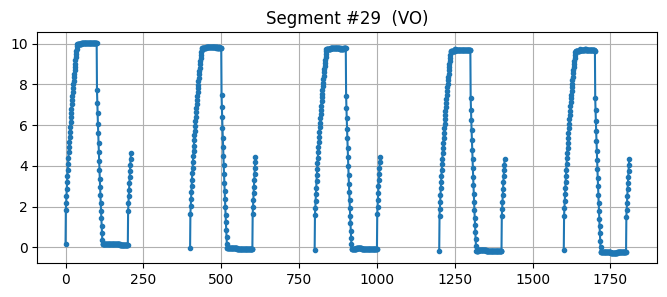

In [27]:
import random
import matplotlib.pyplot as plt

idx = random.randint(0, len(segments) - 1)
seg = segments[idx]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(seg["VO"].to_numpy(dtype=float), marker=".", linestyle="-")
ax.set_title(f"Segment #{idx}  (VO)")
ax.grid(True)
plt.show()


VO shape: (75826, 400)
row NaN mean: 0.3052690699759976 max: 1.0
col NaN mean: 0.3052690699759976 max: 1.0


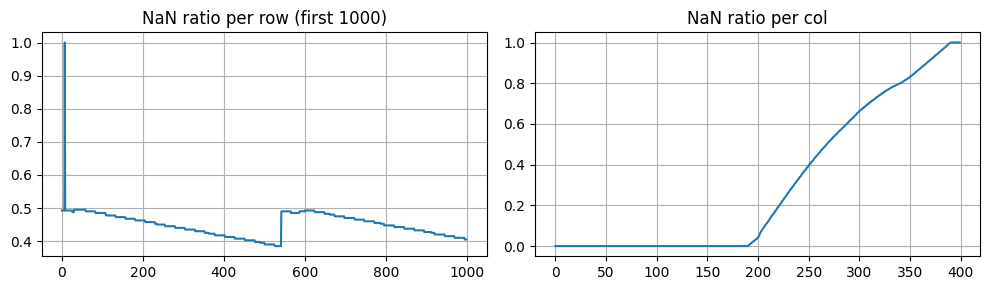

In [28]:
import numpy as np
import matplotlib.pyplot as plt

vo_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VO"], dtype=float)
vl_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VL"], dtype=float)

print("VO shape:", vo_raw.shape)

nan_ratio_row = np.isnan(vo_raw).mean(axis=1)
nan_ratio_col = np.isnan(vo_raw).mean(axis=0)

print("row NaN mean:", nan_ratio_row.mean(), "max:", nan_ratio_row.max())
print("col NaN mean:", nan_ratio_col.mean(), "max:", nan_ratio_col.max())

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(nan_ratio_row[:1000])
axes[0].set_title("NaN ratio per row (first 1000)")
axes[0].grid(True)

axes[1].plot(nan_ratio_col)
axes[1].set_title("NaN ratio per col")
axes[1].grid(True)

plt.tight_layout()


column 0: len(raw)=75826, len(valid)=75820


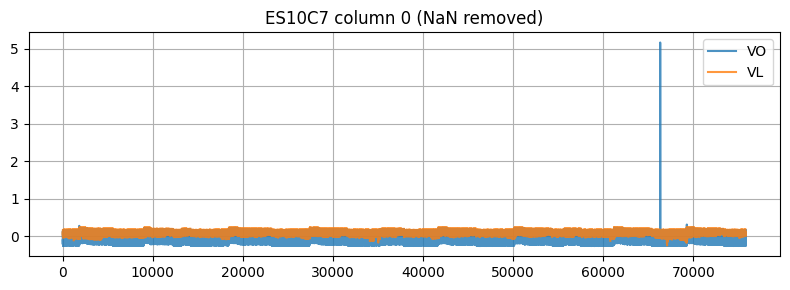

In [29]:
def plot_one_column_waveform(col_idx=0):
    vo_col = vo_raw[:, col_idx]
    vl_col = vl_raw[:, col_idx]

    mask = ~np.isnan(vo_col)
    vo_valid = vo_col[mask]
    vl_valid = vl_col[mask]

    print(f"column {col_idx}: len(raw)={len(vo_col)}, len(valid)={len(vo_valid)}")

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(vo_valid, label="VO", alpha=0.8)
    ax.plot(vl_valid, label="VL", alpha=0.8)
    ax.set_title(f"ES10C7 column {col_idx} (NaN removed)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

plot_one_column_waveform(0)


In [30]:
def features_from_waveform(vo, vl=None, idx=0):
    vo = np.asarray(vo, dtype=float)
    mask = ~np.isnan(vo)
    vo = vo[mask]
    if vo.size == 0:
        return None

    feats = {
        "idx": idx,
        "v_max": vo.max(),
        "v_min": vo.min(),
        "peak_to_peak": vo.max() - vo.min(),
        "rms": np.sqrt(np.mean(vo**2)),
        "slew_rise": np.max(np.diff(vo)),
        "slew_fall": np.min(np.diff(vo)),
        "n_samples": vo.size,
        "nan_ratio": 1.0 - vo.size / len(mask),
    }

    if vl is not None:
        vl = np.asarray(vl, dtype=float)[mask]
        if vl.size > 0:
            feats["vl_rms"] = np.sqrt(np.mean(vl**2))

    return feats


In [31]:
import pandas as pd

rows = []
n_cols = vo_raw.shape[1]

for j in range(n_cols):
    vo_col = vo_raw[:, j]
    vl_col = vl_raw[:, j]
    feats = features_from_waveform(vo_col, vl_col, idx=j)
    if feats is not None:
        rows.append(feats)

feature_df = pd.DataFrame(rows)
feature_df.head()


,idx,v_max,v_min,peak_to_peak,rms,slew_rise,slew_fall,n_samples,nan_ratio,vl_rms
0,0,5.161384,-0.265136,5.426520,0.120547,5.405859,-5.278876,75820,0.000079,NaN
1,1,6.267954,0.346600,5.921354,1.740963,4.776490,-4.636908,75820,0.000079,NaN
2,2,6.584910,1.658257,4.926652,2.102856,4.730635,-4.589039,75820,0.000079,NaN
3,3,6.834846,2.007964,4.826882,2.448172,4.631368,-4.483725,75820,0.000079,NaN
4,4,7.172965,2.342051,4.830914,2.780967,4.635903,-4.477174,75820,0.000079,NaN


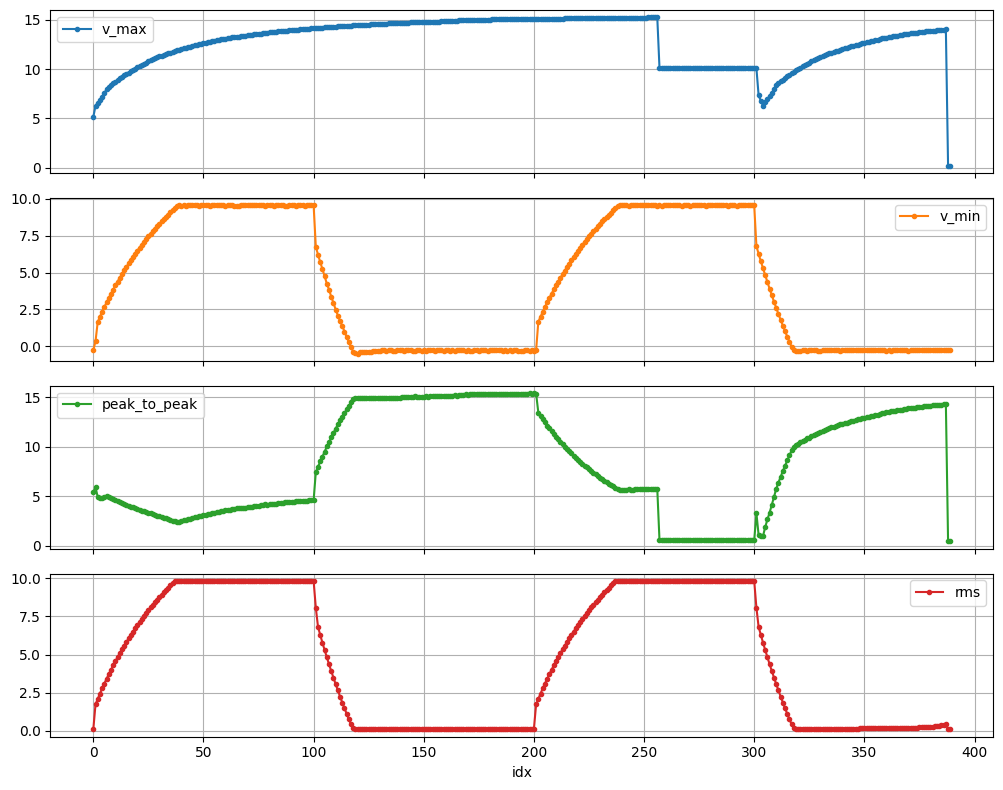

In [32]:
import matplotlib.pyplot as plt

feature_df_sorted = feature_df.sort_values("idx")  # ひとまず列番号順

ax = feature_df_sorted.plot(
    x="idx",
    y=["v_max", "v_min", "peak_to_peak", "rms"],
    subplots=True,
    figsize=(10, 8),
    grid=True,
    marker="."
)
plt.tight_layout()


In [33]:
serial = np.array(f_es10["ES10/Transient_Data/Serial_Date"])
print("Serial shape:", serial.shape)

Serial shape: (75826, 1)


In [34]:
import numpy as np
import pandas as pd

vo_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VO"], dtype=float)
vl_raw = np.array(f_es10["ES10/Transient_Data/ES10C7/VL"], dtype=float)

n_rows, n_cols = vo_raw.shape
print("VO shape:", vo_raw.shape, "VL shape:", vl_raw.shape)


VO shape: (75826, 400) VL shape: (75826, 400)


In [35]:
def estimate_esr_c_from_waveform(vo, vl, idx=0, high_frac=0.8):
    """
    vo, vl: 1D array (1ショット分の VO / VL 波形, NaN込み)
    high_frac: v_max の何割以上を「高レベル」とみなすか
    """
    vo = np.asarray(vo, dtype=float)
    vl = np.asarray(vl, dtype=float)

    # NaN除去
    mask = ~np.isnan(vo)
    vo = vo[mask]
    vl = vl[mask]
    if vo.size < 10:
        return None  # データ少なすぎ

    v_max = vo.max()
    v_min = vo.min()

    # --- ESR proxy: 高レベル期間での VL-VO 平均 ---
    high_thresh = v_max * high_frac
    high_mask = vo > high_thresh
    if high_mask.sum() > 5:
        esr_proxy = float(np.mean(vl[high_mask] - vo[high_mask]))
    else:
        esr_proxy = np.nan  # 高レベル区間取れず

    # --- C proxy: 放電区間の傾きから ---
    # 高レベル → 低レベルに落ちていく区間をざっくり抽出
    # ここでは「vo が v_max*0.9 から v_max*0.3 くらいまで」の範囲を使う
    upper = v_max * 0.9
    lower = v_max * 0.3
    discharge_mask = (vo >= lower) & (vo <= upper)

    if discharge_mask.sum() > 5:
        y = vo[discharge_mask]
        # 仮の時間軸（サンプリング周期は不明なので相対）
        x = np.arange(y.size, dtype=float)

        # 直線近似（V ≒ a x + b）
        a, b = np.polyfit(x, y, 1)  # a ≈ dV/dt

        # 定電流放電モデル V = V0 - (I/C) t より C ∝ -1/a
        if a != 0:
            c_proxy = float(-1.0 / a)
        else:
            c_proxy = np.nan
    else:
        c_proxy = np.nan

    return {
        "idx": idx,
        "v_max": v_max,
        "v_min": v_min,
        "esr_proxy": esr_proxy,
        "c_proxy": c_proxy,
    }


In [36]:
rows = []
for j in range(n_cols):
    vo_col = vo_raw[:, j]
    vl_col = vl_raw[:, j]
    feats = estimate_esr_c_from_waveform(vo_col, vl_col, idx=j)
    if feats is not None:
        rows.append(feats)

esr_c_df = pd.DataFrame(rows).sort_values("idx").reset_index(drop=True)
esr_c_df.head()


,idx,v_max,v_min,esr_proxy,c_proxy
0,0,5.161384,-0.265136,NaN,NaN
1,1,6.267954,0.346600,NaN,3.726341e+06
2,2,6.584910,1.658257,NaN,1.602796e+07
3,3,6.834846,2.007964,NaN,5.950506e+08
4,4,7.172965,2.342051,NaN,-2.736007e+07


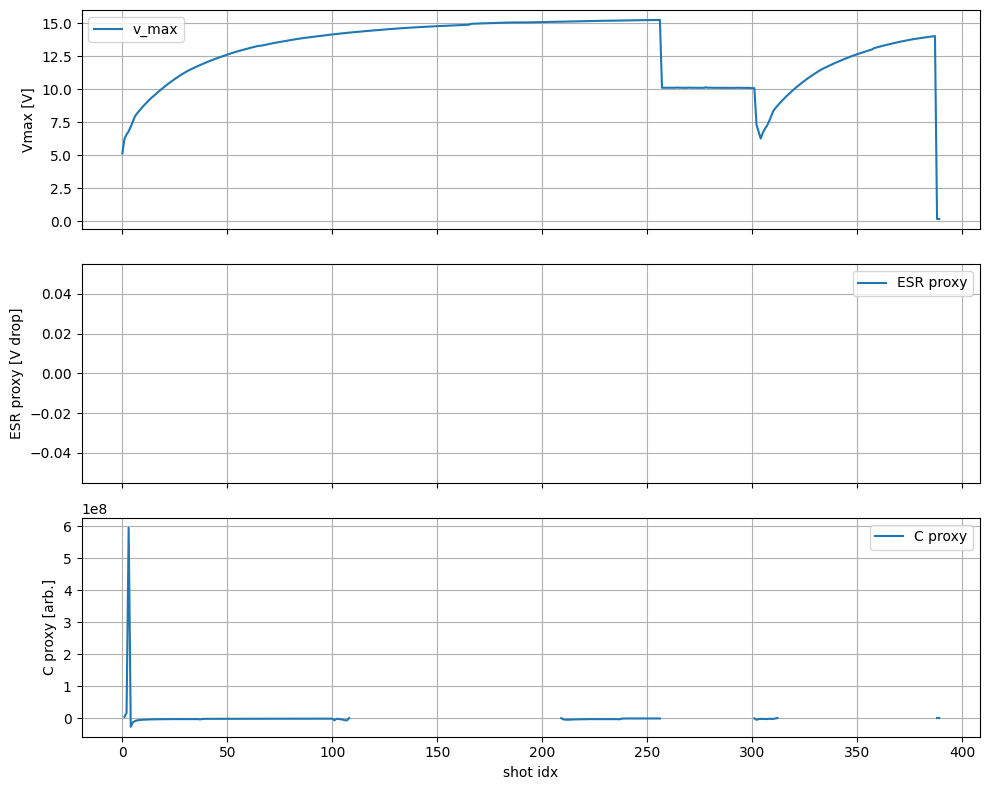

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(esr_c_df["idx"], esr_c_df["v_max"], label="v_max")
axes[0].set_ylabel("Vmax [V]")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(esr_c_df["idx"], esr_c_df["esr_proxy"], label="ESR proxy")
axes[1].set_ylabel("ESR proxy [V drop]")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(esr_c_df["idx"], esr_c_df["c_proxy"], label="C proxy")
axes[2].set_ylabel("C proxy [arb.]")
axes[2].set_xlabel("shot idx")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()


In [38]:
def estimate_esr_c(vo, vl, idx=0):
    vo = np.asarray(vo, float)
    vl = np.asarray(vl, float)

    # remove NaN
    mask = ~np.isnan(vo)
    vo = vo[mask]
    vl = vl[mask]

    if len(vo) < 50:
        return None

    v_max = vo.max()
    v_min = vo.min()

    # -----------------------
    # 1) ESR proxy: voltage drop at discharge start
    # -----------------------
    # find where signal starts falling
    diff = np.diff(vo)
    drop_idx = np.argmin(diff)  # max negative slope

    # ESR ~ ΔV at transition
    esr_window = 5
    before = np.mean(vo[max(0, drop_idx-esr_window):drop_idx])
    after = np.mean(vo[drop_idx:drop_idx+esr_window])
    esr_proxy = before - after  # proportional to ESR

    # -----------------------
    # 2) C proxy: slope of discharge (linear region)
    # -----------------------
    # detect discharge region: values > 5% and < 95% of v_max
    discharge_mask = (vo < 0.95*v_max) & (vo > 0.05*v_max)
    y = vo[discharge_mask]

    # create time relative index
    x = np.arange(len(vo))[discharge_mask]

    # linear fit: V ~ a*t + b → slope = a
    if len(x) > 10:
        slope, intercept = np.polyfit(x, y, 1)
        c_proxy = -1/slope if slope != 0 else np.nan
    else:
        c_proxy = np.nan

    return {
        "idx": idx,
        "v_max": v_max,
        "v_min": v_min,
        "esr_proxy": esr_proxy,
        "c_proxy": c_proxy,
    }


# Apply to all shots
rows = []
for j in range(vo_raw.shape[1]):
    f = estimate_esr_c(vo_raw[:, j], vl_raw[:, j], idx=j)
    if f:
        rows.append(f)

df_esr_c = pd.DataFrame(rows).sort_values("idx")
df_esr_c.head()


,idx,v_max,v_min,esr_proxy,c_proxy
0,0,5.161384,-0.265136,-1.155145,NaN
1,1,6.267954,0.346600,-1.040658,9.659142e+06
2,2,6.584910,1.658257,-1.031286,1.704624e+07
3,3,6.834846,2.007964,-1.014053,1.346533e+08
4,4,7.172965,2.342051,-1.016271,-2.736128e+07


Text(0.5, 1.0, 'Capacitor degradation: C vs ESR over time')

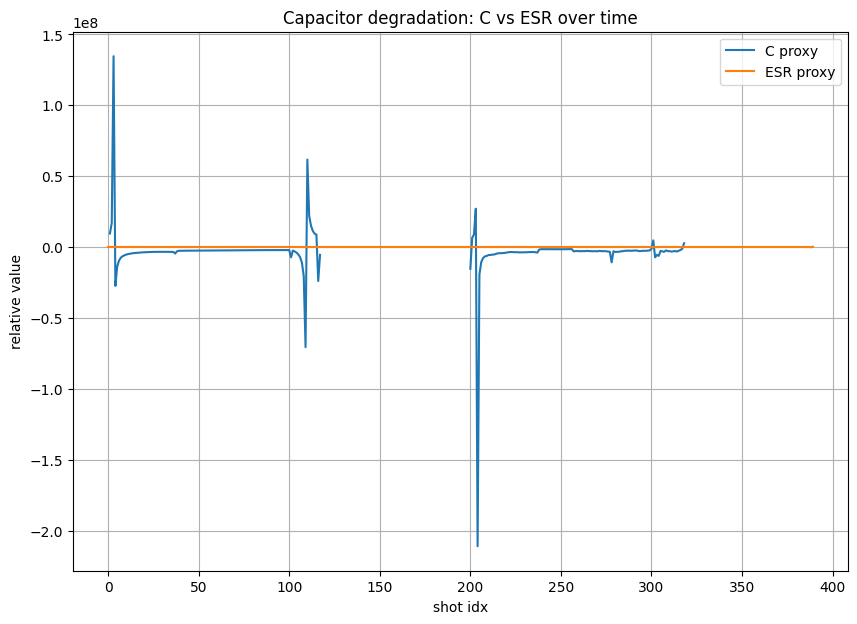

In [39]:
plt.figure(figsize=(10,7))
plt.plot(df_esr_c["idx"], df_esr_c["c_proxy"], label="C proxy")
plt.plot(df_esr_c["idx"], df_esr_c["esr_proxy"], label="ESR proxy")
plt.grid(True)
plt.legend()
plt.xlabel("shot idx")
plt.ylabel("relative value")
plt.title("Capacitor degradation: C vs ESR over time")


In [40]:
import numpy as np
import pandas as pd

def estimate_c_esr_stable(vo, vl, idx=0):
    vo = np.asarray(vo, float)
    vl = np.asarray(vl, float)

    mask = ~np.isnan(vo)
    vo = vo[mask]
    vl = vl[mask]
    if vo.size < 20:
        return None

    v_max = vo.max()
    v_min = vo.min()

    # --- C_proxy: 80% → 20% の時間 ---
    high = 0.8 * v_max
    low  = 0.2 * v_max

    # 80% より上から落ち始めて 20% を下回るまで
    above = np.where(vo >= high)[0]
    below = np.where(vo <= low)[0]

    if len(above) == 0 or len(below) == 0:
        c_proxy = np.nan
    else:
        t_start = above[-1]      # 80% を最後に超えていた時刻
        t_end_candidates = below[below > t_start]
        if len(t_end_candidates) == 0:
            c_proxy = np.nan
        else:
            t_end = t_end_candidates[0]
            c_proxy = float(t_end - t_start)  # サンプル数 = 相対時間

    # --- ESR_proxy: plateau での VL-VO 差分 ---
    plateau_mask = vo > 0.9 * v_max
    if plateau_mask.sum() > 5:
        esr_proxy = float(np.mean(vl[plateau_mask] - vo[plateau_mask]))
    else:
        esr_proxy = np.nan

    return {
        "idx": idx,
        "v_max": v_max,
        "v_min": v_min,
        "c_proxy": c_proxy,
        "esr_proxy": esr_proxy,
    }

# 全ショットに適用
rows = []
for j in range(vo_raw.shape[1]):
    feats = estimate_c_esr_stable(vo_raw[:, j], vl_raw[:, j], idx=j)
    if feats is not None:
        rows.append(feats)

df_ce = pd.DataFrame(rows).sort_values("idx").reset_index(drop=True)
df_ce.head()


,idx,v_max,v_min,c_proxy,esr_proxy
0,0,5.161384,-0.265136,1.0,NaN
1,1,6.267954,0.346600,935.0,NaN
2,2,6.584910,1.658257,NaN,NaN
3,3,6.834846,2.007964,NaN,NaN
4,4,7.172965,2.342051,NaN,NaN


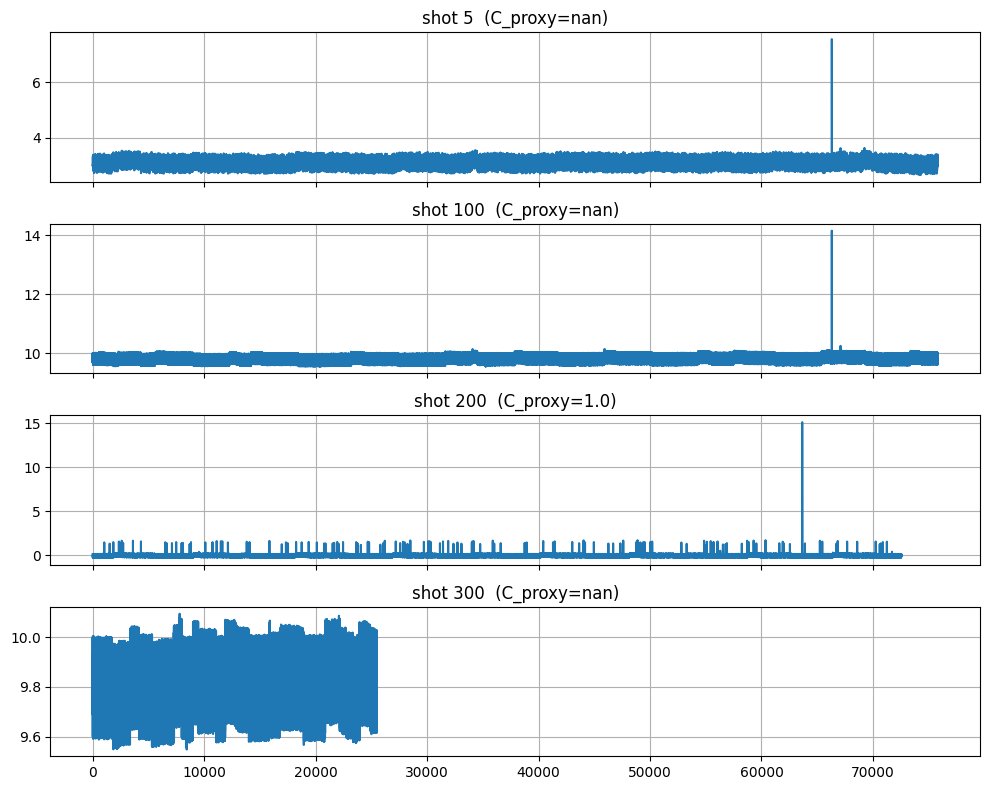

In [41]:
import matplotlib.pyplot as plt

# 適当に「初期・中期・後期」っぽい idx をピックアップ
sample_idxs = [5, 100, 200, 300]  # 必要なら変えてOK

fig, axes = plt.subplots(len(sample_idxs), 1, figsize=(10, 8), sharex=True)

for ax, shot_idx in zip(axes, sample_idxs):
    vo_col = vo_raw[:, shot_idx]
    vo_valid = vo_col[~np.isnan(vo_col)]

    ax.plot(vo_valid, label=f"shot {shot_idx}")
    # C_proxy をタイトルに表示
    c_val = df_ce.loc[df_ce["idx"] == shot_idx, "c_proxy"].values
    if c_val.size > 0:
        ax.set_title(f"shot {shot_idx}  (C_proxy={c_val[0]:.1f})")
    ax.grid(True)

plt.tight_layout()


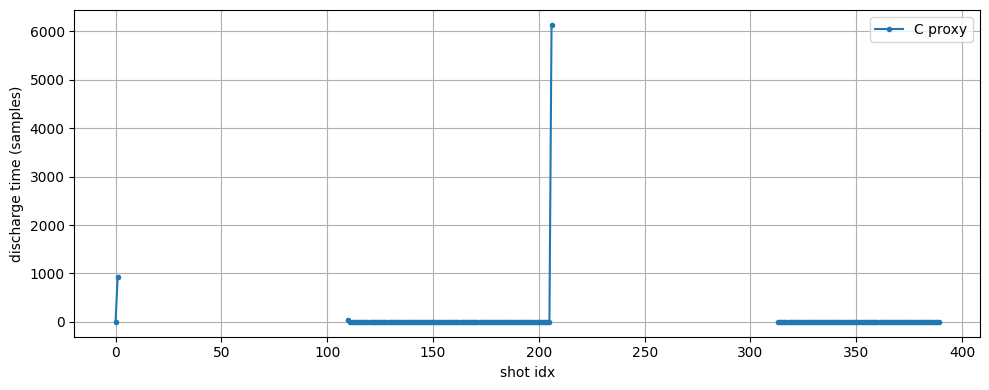

In [42]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df_ce["idx"], df_ce["c_proxy"], marker=".", label="C proxy")
ax.set_xlabel("shot idx")
ax.set_ylabel("discharge time (samples)")
ax.grid(True)
ax.legend()
plt.tight_layout()


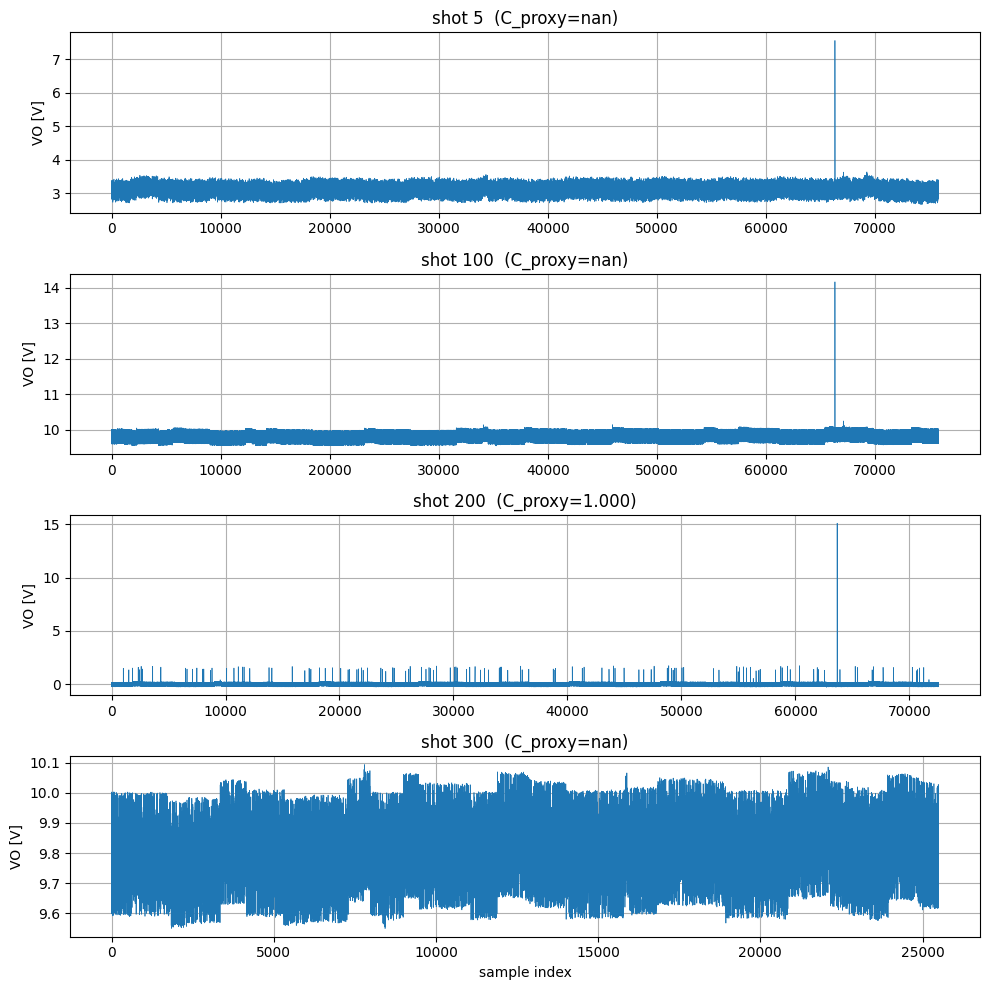

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shots_with_c(vo_raw, df_ce, shot_idxs):
    """
    vo_raw: shape (n_samples, n_shots)
    df_ce : DataFrame with columns ["idx", "c_proxy"]
    shot_idxs: list of shot indices to show, e.g. [5, 100, 200, 300]
    """
    n = len(shot_idxs)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.5 * n), sharex=False)

    if n == 1:
        axes = [axes]

    for ax, shot_idx in zip(axes, shot_idxs):
        vo_col = vo_raw[:, shot_idx]
        vo_valid = vo_col[~np.isnan(vo_col)]

        # C_proxy を取得（なければ NaN）
        row = df_ce.loc[df_ce["idx"] == shot_idx]
        if not row.empty:
            c_val = row["c_proxy"].iloc[0]
        else:
            c_val = np.nan

        ax.plot(vo_valid, linewidth=0.5)
        ax.set_title(f"shot {shot_idx}  (C_proxy={c_val:.3f})")
        ax.set_ylabel("VO [V]")
        ax.grid(True)

    plt.xlabel("sample index")
    plt.tight_layout()

sample_idxs = [5, 100, 200, 300]
plot_shots_with_c(vo_raw, df_ce, sample_idxs)



In [45]:
def plot_shots_and_c_trend(vo_raw, df_ce, shot_idxs):
    n = len(shot_idxs)
    fig, axes = plt.subplots(n + 1, 1, figsize=(10, 2.5 * n + 3), sharex=False)

    # 上 n 個：波形
    for i, shot_idx in enumerate(shot_idxs):
        ax = axes[i]
        vo_col = vo_raw[:, shot_idx]
        vo_valid = vo_col[~np.isnan(vo_col)]

        row = df_ce.loc[df_ce["idx"] == shot_idx]
        c_val = row["c_proxy"].iloc[0] if not row.empty else np.nan

        ax.plot(vo_valid, linewidth=0.5)
        ax.set_title(f"shot {shot_idx}  (C_proxy={c_val:.3f})")
        ax.set_ylabel("VO [V]")
        ax.grid(True)

    # 一番下：C_proxy トレンド
    ax_trend = axes[-1]
    ax_trend.plot(df_ce["idx"], df_ce["c_proxy"], marker=".", linewidth=0.5, label="C_proxy")
    for s in shot_idxs:
        ax_trend.axvline(s, color="r", linestyle="--", alpha=0.5)
    ax_trend.set_xlabel("shot idx")
    ax_trend.set_ylabel("C_proxy (here: rms)")
    ax_trend.grid(True)
    ax_trend.legend()

    plt.tight_layout()


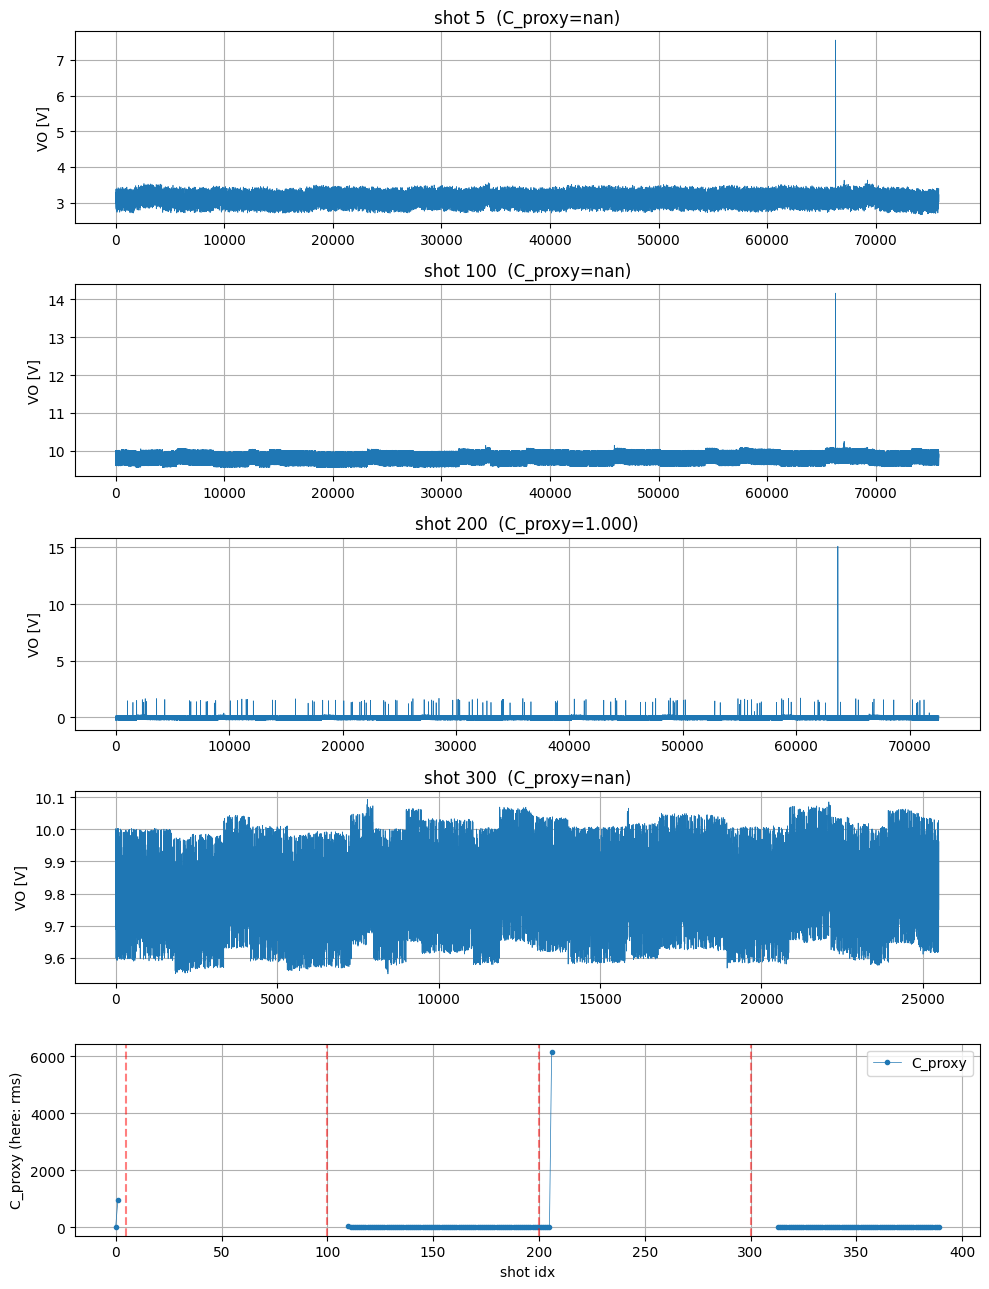

In [46]:
plot_shots_and_c_trend(vo_raw, df_ce, [5, 100, 200, 300])
